# **GUIDE TO UTILIZING THE NUCLS DATASET**

This document offers a concise overview of methods for loading and examining the (NuCLS dataset)[https://huggingface.co/datasets/minhanhto09/NuCLS_dataset]. Additionally, we present a technique for leveraging YOLO for the purpose of nuclei detection.

Outlined below is the structure of this guide:

  1. Loading and Exploring the Dataset
  2. Implementing a **YOLO** Model for the **Nuclei Object Detection** Task
  
    i) Modifying image dimensions and aligning annotation coordinates

    ii) Training the models to update weights

    iii) Assembling the model

    iv) Applying the model

In [ ]:
import pandas as pd
from PIL import Image
!pip install datasets
import datasets
from datasets import DatasetBuilder, GeneratorBasedBuilder, DownloadManager, DatasetInfo, Features, Image, ClassLabel, Value, Sequence, load_dataset, SplitGenerator
import os
import io
from typing import Tuple, Dict, List
import numpy as np
import random
import zipfile
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import matplotlib.cm as cm

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **1. LOAD AND EXPLORE THE DATASET**

There are two versions of the dataset: the full version and the small one, depending on your needs. For quick viewing and debugging, load the small version by adjusting the name argument to `name = debug`. Load the full version by setting `name = default`.

In [ ]:
# @title **1. Load the dataset**
# Load the dataset
#!pip install datasets
#from datasets import load_dataset
test_dataset = load_dataset("minhanhto09/NuCLS_dataset")

In [ ]:
test = test_dataset['test_fold_1']
train = test_dataset['train_fold_1']

file_name: TCGA-AR-A0TS-DX1_id-5ea40971ddda5f839897b6f4_left-122156_top-23832_bottom-24110_right-122442


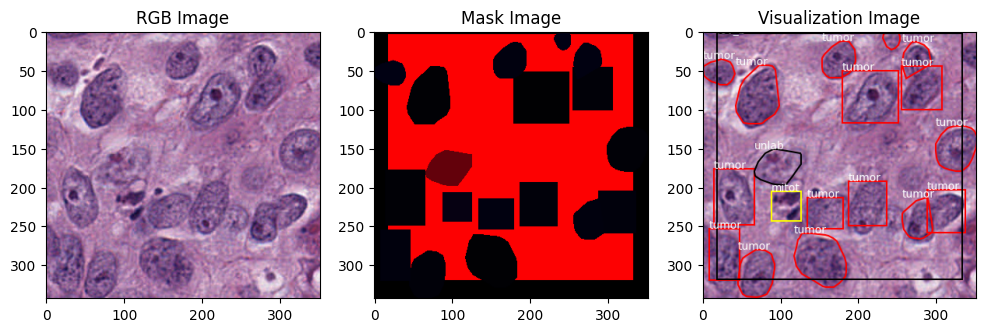

raw_classification: ['tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'unlabeled', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'mitotic_figure', 'tumor']
main_classification: ['tumor_nonMitotic', 'tumor_nonMitotic', 'tumor_nonMitotic', 'tumor_nonMitotic', 'tumor_nonMitotic', 'tumor_nonMitotic', 'tumor_nonMitotic', 'AMBIGUOUS', 'tumor_nonMitotic', 'tumor_nonMitotic', 'tumor_nonMitotic', 'tumor_nonMitotic', 'tumor_nonMitotic', 'tumor_nonMitotic', 'tumor_nonMitotic', 'tumor_nonMitotic', 'tumor_mitotic', 'tumor_nonMitotic']
super_classification: ['tumor_any', 'tumor_any', 'tumor_any', 'tumor_any', 'tumor_any', 'tumor_any', 'tumor_any', 'AMBIGUOUS', 'tumor_any', 'tumor_any', 'tumor_any', 'tumor_any', 'tumor_any', 'tumor_any', 'tumor_any', 'tumor_any', 'tumor_any', 'tumor_any']
type: ['rectangle', 'polyline', 'polyline', 'rectangle', 'polyline', 'polyline', 'rectangle', 'polyline', 'rectangle', 'rectangle', 'polyline', 'polyline', 'rectangle', 'polyl

In [ ]:
# @title **2. An entry of the dataset**

import matplotlib.pyplot as plt
entry_0 = train[0]
print('file_name:', entry_0['file_name'])

# Show 3 images in 1 canvas
rgb_image = entry_0['rgb_image']
mask_image = entry_0['mask_image']
visualization_image = entry_0['visualization_image']

plt.figure(figsize=(12, 7))
plt.subplot(1, 3, 1)
plt.imshow(rgb_image)
plt.title('RGB Image')
plt.subplot(1, 3, 2)
plt.imshow(mask_image)
plt.title('Mask Image')
plt.subplot(1, 3, 3)
plt.imshow(visualization_image)
plt.title('Visualization Image')
plt.show()

# Show annotation coordinates
print('raw_classification:', entry_0['annotation_coordinates']['raw_classification'])
print('main_classification:', entry_0['annotation_coordinates']['main_classification'])
print('super_classification:', entry_0['annotation_coordinates']['super_classification'])
print('type:', entry_0['annotation_coordinates']['type'])
print('xmin:', entry_0['annotation_coordinates']['xmin'])
print('ymin:', entry_0['annotation_coordinates']['ymin'])
print('xmax:', entry_0['annotation_coordinates']['xmax'])
print('ymax:', entry_0['annotation_coordinates']['ymax'])
print('coords_x:', entry_0['annotation_coordinates']['coords_x'])
print('coords_y:', entry_0['annotation_coordinates']['coords_y'])


Image width: 352
Image height: 343
Image resolution: (343, 352, 3)
Image width: 353
Image height: 369
Image resolution: (369, 353, 3)
Image width: 384
Image height: 373
Image resolution: (373, 384, 3)


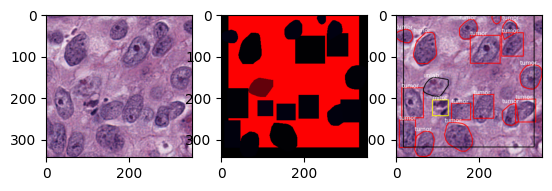

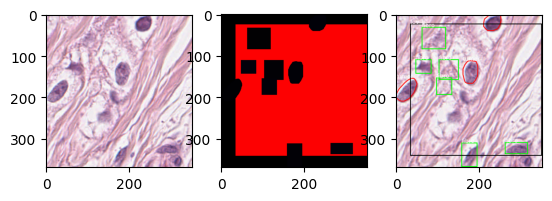

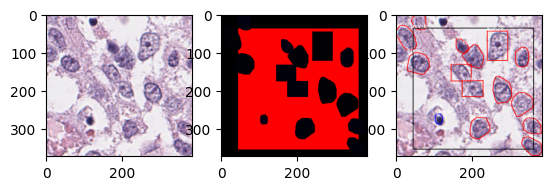

In [ ]:
# 3. Display the first 3 entries' images and their sizes
for i in range(0,3):
    rgb_image = train[i]['rgb_image']
    mask_image = train[i]['mask_image']
    visualization_image = train[i]['visualization_image']

    # Convert to numpy
    rgb_image = np.array(rgb_image)
    mask_image = np.array(mask_image)
    visualization_image = np.array(visualization_image)

    # Display the images
    fig, axes = plt.subplots(1, 3)
    axes[0].imshow(rgb_image)
    axes[1].imshow(mask_image)
    axes[2].imshow(visualization_image)

    # show the image width, height and resolution
    print(f"Image width: {rgb_image.shape[1]}")
    print(f"Image height: {rgb_image.shape[0]}")
    print(f"Image resolution: {rgb_image.shape}")

Unique train hospital codes and their counts: {'AR': 85, 'D8': 183, 'AN': 108, 'A2': 336, 'GM': 126, 'AO': 42, 'E2': 209, 'EW': 138, 'C8': 26, 'A7': 134, 'S3': 43, 'LL': 28, 'AQ': 18, 'GI': 5}
Number of different train hospitals: 14
Unique test hospital codes and their counts: {'AC': 18, 'OL': 114, 'BH': 108, 'A1': 23}
Number of different test hospitals: 4


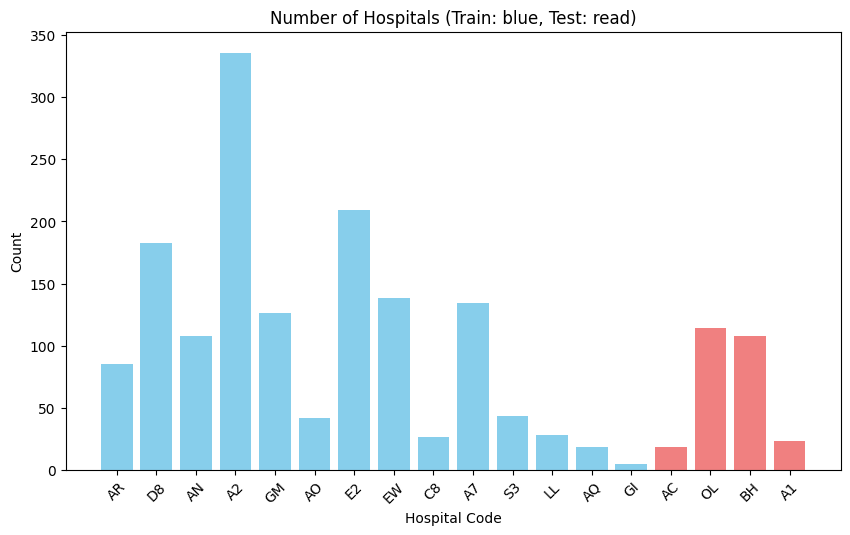

In [ ]:
# @title **3. Exploratory Data Analysis (EDA)**

# Function to count different hospitals from a list
def count_hospitals(file_names):
    hospital_counts = {}
    for file_name in file_names:
        parts = file_name.split("-")
        if len(parts) > 1:
            hospital_code = parts[1]
            if hospital_code not in hospital_counts:
                hospital_counts[hospital_code] = 0
            hospital_counts[hospital_code] += 1
    return hospital_counts

# Count the hospitals
hospital_counts_train = count_hospitals(train['file_name'])
hospital_counts_test = count_hospitals(test['file_name'])

# Combine the counts
combined_counts = {**hospital_counts_train, **hospital_counts_test}

# Printing the result
print(f"Unique train hospital codes and their counts: {hospital_counts_train}")
print(f"Number of different train hospitals: {len(hospital_counts_train)}")
print(f"Unique test hospital codes and their counts: {hospital_counts_test}")
print(f"Number of different test hospitals: {len(hospital_counts_test)}")
#print(f"Combined hospital counts: {combined_counts}")

# Extract hospital codes and their counts
hospital_codes_train = list(hospital_counts_train.keys())
counts_train = list(hospital_counts_train.values())
hospital_codes_test = list(hospital_counts_test.keys())
counts_test = list(hospital_counts_test.values())

# Creating the bar plot
plt.figure(figsize=(10, 6)) # Adjust the size as needed
plt.bar(hospital_codes_train, counts_train, color='skyblue')
plt.bar(hospital_codes_test, counts_test, color='lightcoral')

plt.title('Number of Hospitals (Train: blue, Test: read)')
plt.xlabel('Hospital Code')
plt.ylabel('Count')

# Optional: Rotate the x-axis labels for better readability
# Make the plot a bit smaller
plt.subplots_adjust(bottom=0.15)
plt.xticks(rotation=45)

plt.show()

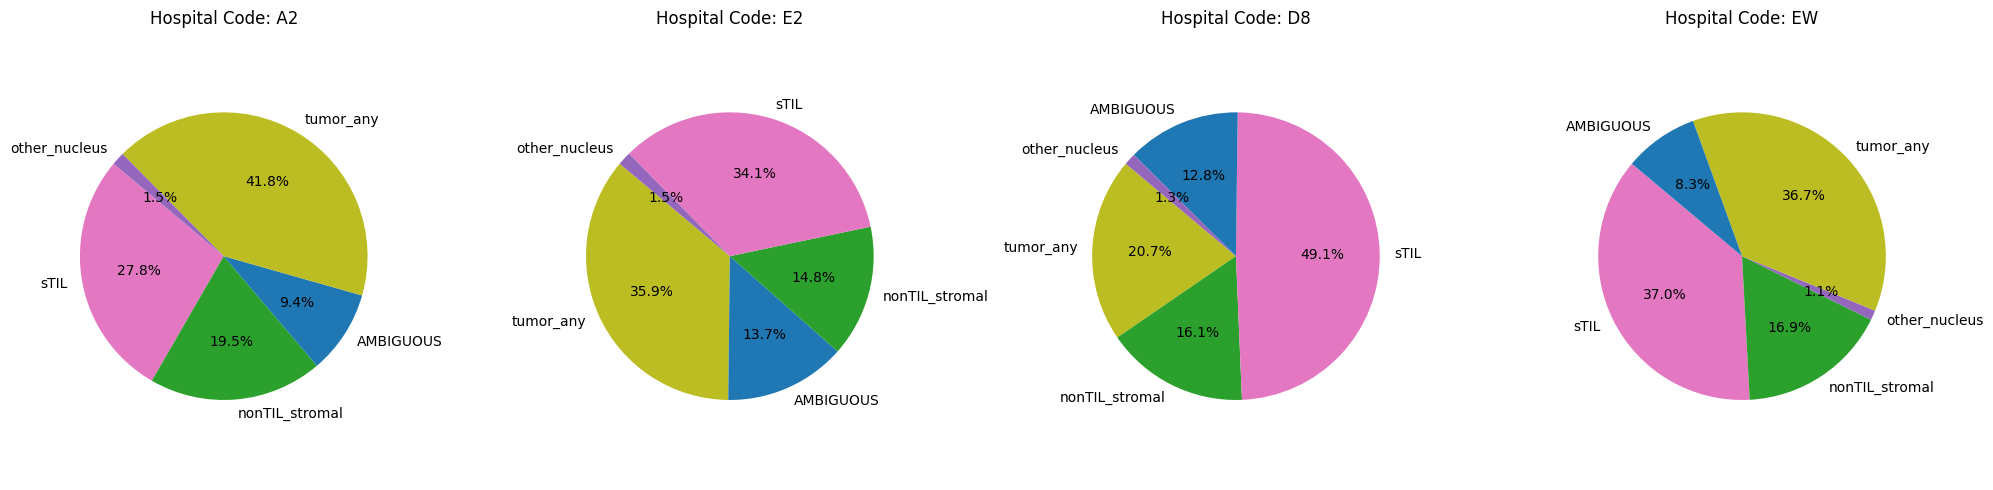

In [ ]:
# Specify the hospital codes for which you want to create pie charts
hospital_codes_to_plot = ['A2', 'E2', 'D8', 'EW']

# Initialize counters for each hospital code
classification_counts = {code: Counter() for code in hospital_codes_to_plot}

# Gather all unique labels from the dataset for the specified hospitals
all_labels = set()
for entry in train:
    file_name = entry['file_name']
    parts = file_name.split("-")
    if len(parts) > 1 and parts[1] in hospital_codes_to_plot:
        classifications = entry["annotation_coordinates"]["super_classification"]
        all_labels.update(classifications)

# Sort labels to maintain consistency
sorted_labels = sorted(all_labels)

# Create a color map: each label gets a color from the colormap
label_colors = {label: cm.tab20(i / len(sorted_labels)) for i, label in enumerate(sorted_labels)}

# Iterate through each entry in the dataset again to fill classification_counts
for entry in train:
    file_name = entry['file_name']
    parts = file_name.split("-")
    if len(parts) > 1:
        hospital_code = parts[1]
        if hospital_code in hospital_codes_to_plot:
            # Extract classifications and update the counter for the relevant hospital
            classifications = entry["annotation_coordinates"]["super_classification"]
            classification_counts[hospital_code].update(classifications)

# Plotting the pie charts with color consistency
fig, axs = plt.subplots(1, 4, figsize=(20, 5))  # Adjust the figsize as needed
for i, hospital_code in enumerate(hospital_codes_to_plot):
    labels = list(classification_counts[hospital_code].keys())
    sizes = list(classification_counts[hospital_code].values())
    colors = [label_colors[label] for label in labels]  # Get the colors for current labels

    if labels and sizes:  # Ensure there's data to plot
        axs[i].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
        axs[i].axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle
        axs[i].set_title(f'Hospital Code: {hospital_code}')
    else:
        axs[i].text(0.5, 0.5, 'No Data', ha='center', va='center', fontsize=12)
        axs[i].set_title(f'Hospital Code: {hospital_code}')

plt.tight_layout()
plt.show()


In [ ]:
# Function to aggregate nuclei frequencies
def aggregate_nuclei_frequencies(dataset):
    hospital_nuclei_counts = defaultdict(Counter)

    for entry in dataset:
        # Extract hospital code from the file_name
        hospital_code = entry['file_name'].split('-')[1]
        # Aggregate the count of each nucleus type
        for nucleus_type in entry['annotation_coordinates']['raw_classification']:
            hospital_nuclei_counts[hospital_code][nucleus_type] += 1

    return hospital_nuclei_counts

train_fold_1_counts = aggregate_nuclei_frequencies(train)
test_fold_1_counts = aggregate_nuclei_frequencies(test)

# Combine aggregated data
combined_counts = {**train_fold_1_counts, **test_fold_1_counts}
for key in combined_counts:
    if key in train_fold_1_counts and key in test_fold_1_counts:
        combined_counts[key] = combined_counts[key] + test_fold_1_counts[key]

{'AR': Counter({'lymphocyte': 1020, 'tumor': 853, 'unlabeled': 563, 'fibroblast': 375, 'plasma_cell': 239, 'macrophage': 84, 'apoptotic_body': 44, 'vascular_endothelium': 31, 'mitotic_figure': 4}), 'D8': Counter({'lymphocyte': 2203, 'tumor': 1214, 'fibroblast': 769, 'unlabeled': 742, 'plasma_cell': 696, 'macrophage': 126, 'ductal_epithelium': 77, 'vascular_endothelium': 55, 'apoptotic_body': 11, 'mitotic_figure': 6, 'eosinophil': 1}), 'AN': Counter({'tumor': 1741, 'lymphocyte': 1197, 'unlabeled': 876, 'fibroblast': 435, 'plasma_cell': 163, 'mitotic_figure': 64, 'apoptotic_body': 48, 'vascular_endothelium': 46, 'macrophage': 32}), 'A2': Counter({'tumor': 4731, 'lymphocyte': 2036, 'fibroblast': 2009, 'plasma_cell': 1130, 'unlabeled': 990, 'macrophage': 156, 'ductal_epithelium': 118, 'apoptotic_body': 79, 'vascular_endothelium': 62, 'myoepithelium': 48, 'mitotic_figure': 36, 'neutrophil': 1}), 'GM': Counter({'lymphocyte': 1170, 'tumor': 1070, 'unlabeled': 841, 'fibroblast': 591, 'macropha

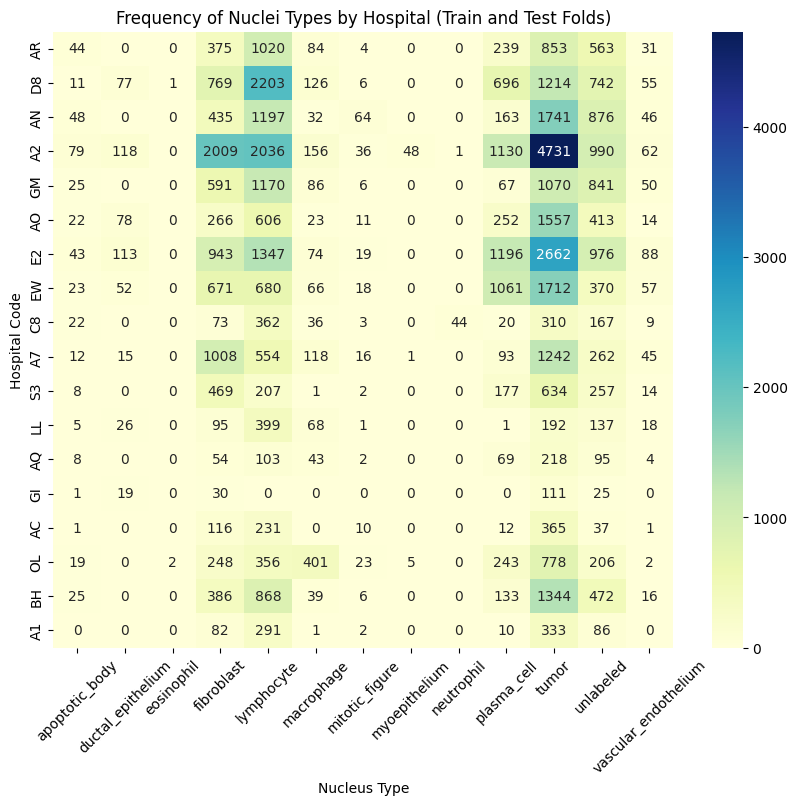

In [ ]:
# Assuming combined_counts is the aggregated data
labels = list(combined_counts.keys())  # Hospital codes

# Generating a list of unique nuclei types
nuclei_types = set()
for counts in combined_counts.values():
    nuclei_types.update(counts.keys())
nuclei_types = sorted(list(nuclei_types))  # Sorting to maintain a consistent order

# Generating the matrix for the heatmap
matrix = np.array([[combined_counts[hospital].get(nucleus, 0) for nucleus in nuclei_types] for hospital in labels])

# Creating a heatmap with the corrected data

plt.figure(figsize=(10, 8))
sns.heatmap(matrix, annot=True, fmt="d", cmap="YlGnBu", xticklabels=nuclei_types, yticklabels=labels)
plt.xticks(rotation=45)
plt.title('Frequency of Nuclei Types by Hospital (Train and Test Folds)')
plt.xlabel('Nucleus Type')
plt.ylabel('Hospital Code')
plt.show()


### **INTERPRETATION**

**The bar chart** illustrates each hospital's contribution to the dataset, with longer bars indicating higher sample counts. This underscores potential biases, as models might more accurately predict conditions from hospitals contributing more data.

**The pie charts** offer a snapshot of the cellular composition within histological samples from various hospitals, showcasing the diversity of cell types present. In histopathology, stromal Tumor-Infiltrating Lymphocytes (sTILs) and non-TIL stromal cells (which may include fibroblasts or vascular endothelial cells) serve distinct roles within the tumor microenvironment. Their presence is not inherently "dangerous," but rather reflective of the body's reaction to the tumor or the tumor's characteristics themselves. Such cellular indicators provide crucial insights into the tumor's milieu, aiding pathologists and oncologists in diagnosing and formulating treatment plans.

**The heatmap** presents the distribution of various nuclei types across hospitals. Darker shades denote higher frequencies, highlighting prevalent conditions in specific hospitals, such as significant occurrences of 'tumor' nuclei, potentially signifying a specialization in cancer treatment. It also delineates the distribution of other common nuclei like 'fibroblast' or 'lymphocyte'. Conversely, lighter shades indicate less common nuclei types, suggesting lower incidence rates or possible biases in sample collection.

Overall, these visualizations equip pathologists and health experts with the ability to rapidly identify trends and anomalies, enhancing the interpretation of data and supporting more informed healthcare decisions.

## **2. RUN A YOLO MODEL FOR NUCLEI DETECTION TASK**

### 1. **Resources**

This implementation follows closely with the structure of how to train a custom object detection model with YOLO: https://neptune.ai/blog/object-detection-with-yolo-hands-on-tutorial.

Here is the link to the Github repository: https://github.com/taipingeric/yolo-v4-tf.keras/tree/master.

### 2. **Discussions and implementation**

One significant obstacle in applying the YOLO model to this dataset stems from the variability in image dimensions. Each image is paired with a detailed set of annotation coordinates that encapsulate comprehensive data about every nucleus and its respective label—think of it as a dedicated CSV file accompanying each image group. Consequently, we must devise a method to uniformly resize the images while correspondingly adjusting the annotation coordinates. Unlike models such as YOLOv5, which typically assign a single label to an entire image, our challenge is compounded by having multiple labels for various elements within a single image.

The secondary challenge involves transforming the image_name and annotation coordinates into a single text file, while the array of labels must be converted into a separate text file.

Below are the steps that I implemented to circumvent the above two problems.

In [ ]:
# @title **i) Resize Images and Adjust Annotation Coordinates**
#!pip install Pillow numpy
import numpy as np
from PIL import Image, ImageOps
# Functions to resize image and adjust annotation coordinates

def resize_image(image, target_size=(416, 416)):
    """
    Resize an image while preserving its aspect ratio. Adds padding to maintain the aspect ratio.
    Returns the resized image and the scale factors for width and height.
    """
    # Calculate the scale needed for each side
    scale = min(target_size[0] / image.width, target_size[1] / image.height)

    # Calculate the new size and resize the image
    new_size = (int(image.width * scale), int(image.height * scale))
    resized_image = image.resize(new_size, Image.ANTIALIAS)

    # Calculate padding
    #padding = (target_size[0] - new_size[0], target_size[1] - new_size[1])
    #padding = (padding[0] // 2, padding[1] // 2, padding[0] - padding[0] // 2, padding[1] - padding[1] // 2)
    padding = (
    (target_size[0] - new_size[0]) // 2,  # Left padding
    (target_size[1] - new_size[1]) // 2,  # Top padding
    (target_size[0] - new_size[0]) - (target_size[0] - new_size[0]) // 2,  # Right padding
    (target_size[1] - new_size[1]) - (target_size[1] - new_size[1]) // 2   # Bottom padding
)
    # Add padding
    padded_image = ImageOps.expand(resized_image, padding)

    return padded_image, scale, padding[:2]

def adjust_annotation_coordinates(coords, original_size, scale, padding):
    """
    Adjust the annotation coordinates based on the image scaling and padding.
    """
    adjusted_coords = {}
    for key in ['xmin', 'ymin', 'xmax', 'ymax']:
        scaled_coords = np.array(coords[key]) * scale
        if 'x' in key:
            adjusted_coords[key] = (scaled_coords + padding[0]).tolist()
        else:
            adjusted_coords[key] = (scaled_coords + padding[1]).tolist()

    # Assuming coords_x and coords_y are lists of lists
    adjusted_coords['coords_x'] = [[x * scale + padding[0] for x in poly] for poly in coords['coords_x']]
    adjusted_coords['coords_y'] = [[y * scale + padding[1] for y in poly] for poly in coords['coords_y']]

    return adjusted_coords


In [ ]:
# Apply the image padding on all rgb, mask and visualization images in the train dataset
adj_mask_images_train = []
adj_rgb_images_train = []
adj_visualization_images_train = []
adj_coordinates_train = []

# Run the resize_image and adjust_annotation_coordinates functions through the entire train set and append it to the empty list coordinates

for item in train:
    adjusted_rgb_image, scale, padding = resize_image(item['rgb_image'])
    adj_rgb_images_train.append(adjusted_rgb_image)

    adjusted_mask_image, scale, padding = resize_image(item['mask_image'])
    adj_mask_images_train.append(adjusted_mask_image)

    #adjusted_visualziation_image, scale, padding = resize_image(item['visualization_image'])
    #adj_visualization_images_train.append(adjusted_visualziation_image)

    adjusted_annotation_coordinates = adjust_annotation_coordinates(
        item['annotation_coordinates'], item['rgb_image'].size, scale, padding
    )
    adj_coordinates_train.append(adjust_annotation_coordinates(
        item['annotation_coordinates'], item['rgb_image'].size, scale, padding
    ))


<ipython-input-13-dac60021810b>:17: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = image.resize(new_size, Image.ANTIALIAS)


In [ ]:
# Apply the image padding on all rgb, mask and visualization images in the test dataset
adj_mask_images_test = []
adj_rgb_images_test = []
adj_visualization_images_test = []
adj_coordinates_test = []

# Run the resize_image and adjust_annotation_coordinates functions through the entire train set and append it to the empty list coordinates

for item in test:
    adjusted_rgb_image, scale, padding = resize_image(item['rgb_image'])
    adj_rgb_images_test.append(adjusted_rgb_image)

    adjusted_mask_image, scale, padding = resize_image(item['mask_image'])
    adj_mask_images_test.append(adjusted_mask_image)

    adjusted_visualization_image, scale, padding = resize_image(item['visualization_image'])
    adj_visualization_images_test.append(adjusted_visualization_image)

    adjusted_annotation_coordinates = adjust_annotation_coordinates(
        item['annotation_coordinates'], item['rgb_image'].size, scale, padding
   )
    adj_coordinates_test.append(adjust_annotation_coordinates(
        item['annotation_coordinates'], item['rgb_image'].size, scale, padding
    ))

<ipython-input-13-dac60021810b>:17: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = image.resize(new_size, Image.ANTIALIAS)


In [ ]:
# @title **ii) Create a Label dictionary (a label .txt file to feed into the model)**
labels_dict = {
  'fov': 0, # dummy variable to feed into the model
  'tumor': 1,
  'fibroblast': 2,
  'lymphocyte': 3,
  'plasma_cell': 4,
  'macrophage': 5,
  'mitotic_figure': 6,
  'vascular_endothelium': 7,
  'myoepithelium': 8,
  'apoptotic_body': 9,
  'neutrophil': 10,
  'ductal_epithelium': 11,
  'eosinophil': 12,
  'unlabeled': 13
}

# create a function that maps the label to its value
def map_label_to_value(label):
    return labels_dict[label]

In [ ]:
# @title **iii) Create a coordinate .txt file to feed into the model**

def extract_coordinates(image_dict, the_adjusted_coordinates):
    # one image, one list of adjusted coordinates
    coordinates = []
    # Determine the number of coordinates by checking the length of one of the lists
    num_coordinates = len(image_dict['annotation_coordinates']['xmin'])

    # Loop through each coordinate
    for i in range(num_coordinates):
        xmin = the_adjusted_coordinates['xmin'][i]
        ymin = the_adjusted_coordinates['ymin'][i]
        xmax = the_adjusted_coordinates['xmax'][i]
        ymax = the_adjusted_coordinates['ymax'][i]
        label = map_label_to_value(image_dict['annotation_coordinates']['raw_classification'][i])
        # Append a formatted string with the current coordinates and label to the list
        filename = image_dict['file_name']+".png"
        coordinates.append(f"{int(xmin)},{int(ymin)},{int(xmax)},{int(ymax)},{label}")

    coordinates = ' '.join(coordinates)
    fully_formatted_coordinates = f"{filename} {coordinates}"
    return fully_formatted_coordinates

In [ ]:
# Create a coordinate .txt file for train data
all_adjusted_coordinates_with_labels_train = []
for i, image_dict in enumerate(train):
    result = extract_coordinates(image_dict, adj_coordinates_train[i])
    all_adjusted_coordinates_with_labels_train.append(result)
all_adjusted_coordinates_with_labels_train[0:4] # Print out the first rows to double-check

['TCGA-AR-A0TS-DX1_id-5ea40971ddda5f839897b6f4_left-122156_top-23832_bottom-24110_right-122442.png 211,66,296,140,1 138,313,217,390,1 49,58,115,141,1 16,215,78,295,1 353,150,416,213,1 53,338,108,405,1 9,306,55,379,1 78,185,148,235,13 221,234,278,296,1 340,247,398,307,1 302,259,348,316,1 180,21,231,72,1 158,259,212,301,1 302,22,346,73,1 0,48,48,82,1 273,5,299,29,1 104,249,148,289,6 301,59,362,120,1',
 'TCGA-D8-A1JF-DX1_id-5ea40a71ddda5f839898f744_left-27396_top-53092_bottom-53390_right-27681.png 10,175,67,247,1 192,128,233,199,1 249,0,296,56,1 81,37,145,105,2 189,351,230,425,2 127,125,180,189,2 307,350,368,391,2 120,174,162,229,2 64,125,105,172,2',
 'TCGA-D8-A1JL-DX1_id-5ea40a9bddda5f839899203f_left-44336_top-29155_bottom-29456_right-44646.png 276,184,329,255,1 329,230,391,292,1 0,39,58,102,1 189,93,249,154,1 32,116,95,172,1 211,301,267,356,1 361,302,413,342,1 340,101,378,151,1 44,6,85,46,1 171,77,206,112,1 111,290,133,314,3 358,357,416,404,1 260,55,318,133,1 188,196,248,236,1 157,150,2

In [ ]:
# Create a coordinate .txt file for test data
all_adjusted_coordinates_with_labels_test = []
for i, image_dict in enumerate(test):
    result = extract_coordinates(image_dict, adj_coordinates_test[i])
    all_adjusted_coordinates_with_labels_test.append(result)
all_adjusted_coordinates_with_labels_test[0:4]

['TCGA-AC-A2BK-DX1_id-5ea40a4dddda5f839898d7d9_left-16957_top-9598_bottom-9887_right-17217.png 257,0,321,86,1 155,316,195,374,1 62,113,103,167,2 39,241,72,291,3 358,382,384,437,3 105,148,135,198,3 145,280,175,326,3 83,20,112,69,3 247,147,277,195,3 240,99,265,151,3 288,220,312,271,3 318,130,343,181,3 307,80,334,129,3 218,161,247,208,3 282,146,306,195,3 258,277,283,326,3 266,86,291,134,3 136,91,161,137,3 173,27,205,82,3 230,65,263,118,3 29,77,86,139,1 289,269,338,330,1 27,172,70,240,1 323,244,367,303,1 299,373,343,419,2 318,177,350,230,3 79,362,96,423,2 338,160,370,207,3 161,258,201,296,3 218,275,250,319,3 144,348,173,395,2 368,280,391,331,3 208,104,238,147,2 41,353,70,394,2 34,281,55,330,2 111,302,136,346,3 350,121,376,162,3 200,130,223,174,2 269,176,291,219,3 66,332,89,376,3 82,274,111,312,3 247,200,271,245,2 42,41,66,81,2 206,346,226,390,3 229,376,249,419,3 325,362,349,402,3 205,241,224,275,3 64,34,79,75,3 22,32,41,67,2 357,81,389,142,13 166,74,194,135,13',
 'TCGA-OL-A66P-DX1_id-5ea40

# **BUILDING THE YOLO MODEL**

In [ ]:
# @title Clone the gibhub repository
#!git clone https://github.com/taipingeric/yolo-v4-tf.keras.git

In [2]:
%cd /content/drive/MyDrive/YOLO/yolo-v4-tf.keras

/content/drive/MyDrive/YOLO/yolo-v4-tf.keras


In [ ]:
# Create train/test folders
!mkdir fp_train fp_test
!mkdir fp_train/images fp_train/labels fp_test/images fp_test/labels

In [ ]:
fp_train_path = '/content/drive/MyDrive/YOLO/fp_train'
fp_test_path = '/content/drive/MyDrive/YOLO/fp_test'

fp_train_images_path = 'fp_train/images'
fp_train_labels_path = 'fp_train/labels'
fp_test_images_path = 'fp_test/images'
fp_test_labels_path = 'fp_test/labels'

In [ ]:
# Write the all_adjusted_coordinates_with_labels_test results into a new txt file
with open(fp_test_labels_path+'.txt', 'w') as f:
    for item in all_adjusted_coordinates_with_labels_test:
        f.write(item + '\n')


# Write the all_adjusted_coordinates_with_labels results into a new txt file
with open(fp_train_labels_path+'.txt', 'w') as f:
    for item in all_adjusted_coordinates_with_labels_train:
        f.write(item + '\n')


In [ ]:
# save all images in adj_rgb_images to sp_train_images_path
import os
import shutil

for i, image in enumerate(adj_rgb_images_test):
    save_path_test = os.path.join(fp_test_images_path, test[i]['file_name']+ '.png')
    print(save_path_test)
    image.save(save_path_test)

In [ ]:
# save all images in adj_rgb_images to sp_train_images_path
for i, image in enumerate(adj_rgb_images_train):
    save_path_train = os.path.join(fp_train_images_path, train[i]['file_name']+ '.png')
    print(save_path_train)
    image.save(save_path_train)

In [ ]:
# Load packages

from utilsdebug2 import DataGenerator #, read_annotation_lines
from models import Yolov4
import keras
from keras.callbacks import ReduceLROnPlateau, TensorBoard, ModelCheckpoint, EarlyStopping
import os

In [ ]:
FOLDER_PATH = 'fp_train/images'
class_name_path = 'fp_train/labels/nucleus_labels.txt'
FOLDER_PATH_TEST = 'fp_test/images'
data_gen_train = DataGenerator(train_lines,
                              class_name_path,
                              FOLDER_PATH)
data_gen_val = DataGenerator(test_lines,
                             class_name_path,
                             FOLDER_PATH_TEST)

In [ ]:
#from models import Yolov4
model = Yolov4(weight_path='yolov4(1).weights',
               class_name_path='class_names/coco_classes.txt')

nms iou: 0.413 score: 0.3
all weights read
load from yolov4(1).weights


In [ ]:
model.predict('img/crosswalk-featured.jpg')

In [ ]:
def read_annotation_lines(annotation_path, test_size=None, random_seed=5566):
    with open(annotation_path) as f:
        lines = f.readlines()
    return lines
    # if test_size:
    #     return train_test_split(lines, test_size=test_size, random_state=random_seed)
    # else:
    #     return lines

In [ ]:
train_lines = read_annotation_lines('fp_train/labels.txt')
test_lines = read_annotation_lines('fp_test/labels.txt')
FOLDER_PATH_TRAIN = 'fp_train/images'
FOLDER_PATH_TEST = 'fp_test/images'
class_name_path = 'nucleus_labels.txt'
data_gen_train = DataGenerator(train_lines,
                              class_name_path,
                              FOLDER_PATH_TRAIN)
data_gen_val = DataGenerator(test_lines,
                             class_name_path,
                             FOLDER_PATH_TEST)

In [ ]:
model = Yolov4(weight_path=None,
               class_name_path=class_name_path)

nms iou: 0.413 score: 0.3


In [ ]:
 # defining pathes and callbacks

dir4saving = 'path2checkpoint/checkpoints'
os.makedirs(dir4saving, exist_ok = True)

logdir = 'path4logdir/logs'
os.makedirs(logdir, exist_ok = True)

name4saving = 'epoch_{epoch:02d}-val_loss-{val_loss:.4f}.hdf5'

filepath = os.path.join(dir4saving, name4saving)

rLrCallBack = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                             factor = 0.1,
                                             patience = 5,
                                             verbose = 1)

tbCallBack = keras.callbacks.TensorBoard(log_dir = logdir,
                                         histogram_freq = 0,
                                         write_graph = False,
                                         write_images = False)

mcCallBack_loss = keras.callbacks.ModelCheckpoint(filepath,
                                            monitor = 'val_loss',
                                            verbose = 1,
                                            save_best_only = True,
                                            save_weights_only = False,
                                            mode = 'auto',
                                            save_freq = 'epoch')

esCallBack = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                          mode = 'min',
                                          verbose = 1,
                                          patience = 10)

In [ ]:
model2 = model.fit(
    data_gen_train,
    initial_epoch=0,
    epochs=2,
    val_data_gen=data_gen_val,
    callbacks=[]
)

Epoch 1/2
 80/186 [===========>..................] - ETA: 1:06 - loss: 2138.3647

/content/drive/MyDrive/YOLO/yolo-v4-tf.keras/utilsdebug2.py:273: RuntimeWarning: invalid value encountered in divide
  iou = intersect_area / (box_area + anchor_area - intersect_area)  # (# of bbox, 9)


186/186 [==============================] - 127s 679ms/step - loss: 2088.0022 - val_loss: 1535.7665
Epoch 2/2
186/186 [==============================] - 130s 696ms/step - loss: 1971.9198 - val_loss: 1890.5812


In [ ]:
model4 = model.fit(
    data_gen_train,
    initial_epoch=0,
    epochs=4,
    val_data_gen=data_gen_val,
    callbacks=[]
)

Epoch 1/4
186/186 [==============================] - ETA: 0s - loss: 3186.4021

/content/drive/MyDrive/YOLO/yolo-v4-tf.keras/utilsdebug2.py:273: RuntimeWarning: invalid value encountered in divide
  iou = intersect_area / (box_area + anchor_area - intersect_area)  # (# of bbox, 9)


186/186 [==============================] - 129s 691ms/step - loss: 3186.4021 - val_loss: 3346.4329
Epoch 2/4
186/186 [==============================] - 130s 696ms/step - loss: 2597.8235 - val_loss: 2187.7471
Epoch 3/4
186/186 [==============================] - 130s 696ms/step - loss: 2361.5605 - val_loss: 2220.4675
Epoch 4/4
186/186 [==============================] - 130s 699ms/step - loss: 2365.2290 - val_loss: nan


In [ ]:
model.fit(data_gen_train,
          initial_epoch=0,
          epochs=10,
          val_data_gen=data_gen_val,
          callbacks=[])

Epoch 1/10
186/186 [==============================] - 130s 697ms/step - loss: 1995.3835 - val_loss: 1825.6346
Epoch 2/10
186/186 [==============================] - 129s 694ms/step - loss: 2008.1782 - val_loss: 1826.2854
Epoch 3/10
186/186 [==============================] - 129s 696ms/step - loss: 2158.1282 - val_loss: 1703.8037
Epoch 4/10
186/186 [==============================] - 129s 693ms/step - loss: 2111.2622 - val_loss: 2067.8564
Epoch 5/10
186/186 [==============================] - 129s 694ms/step - loss: 2033.6068 - val_loss: 1776.0182
Epoch 6/10
186/186 [==============================] - 129s 695ms/step - loss: 2185.6724 - val_loss: 2277.1340
Epoch 7/10
186/186 [==============================] - 129s 694ms/step - loss: 2065.2793 - val_loss: 2066.2986
Epoch 8/10
186/186 [==============================] - 129s 693ms/step - loss: 2100.3413 - val_loss: 1785.9419
Epoch 9/10
186/186 [==============================] - 129s 694ms/step - loss: 2003.7031 - val_loss: 1880.4020
Epoch 10/1

img shape:  (416, 416, 3)
1/1 [==============================] - 3s 3s/step
# of bboxes: 0


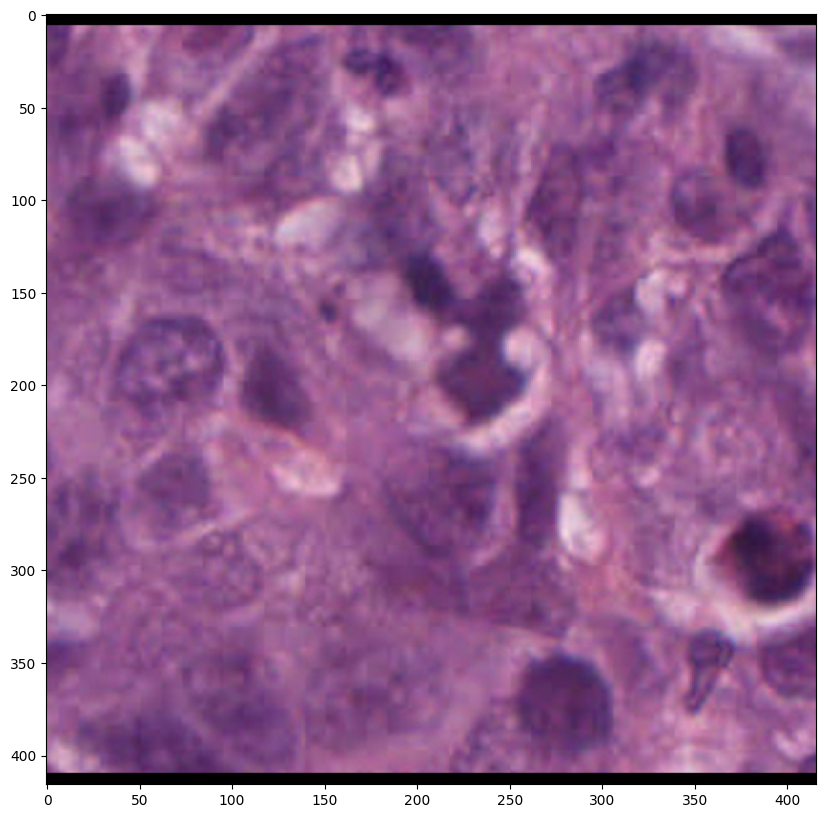

,x1,y1,x2,y2,class_name,score,w,h


In [ ]:
model.predict('fp_test/images/TCGA-A1-A0SP-DX1_id-5ea4095addda5f8398977ebc_left-11371_top-54469_bottom-54761_right-11671.png')

In [ ]:
%%writefile utilsdebug2.py
# second version
import numpy as np
import cv2
import pandas as pd
import operator
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
from config import yolo_config


def load_weights(model, weights_file_path):
    conv_layer_size = 110
    conv_output_idxs = [93, 101, 109]
    with open(weights_file_path, 'rb') as file:
        major, minor, revision, seen, _ = np.fromfile(file, dtype=np.int32, count=5)

        bn_idx = 0
        for conv_idx in range(conv_layer_size):
            conv_layer_name = f'conv2d_{conv_idx}' if conv_idx > 0 else 'conv2d'
            bn_layer_name = f'batch_normalization_{bn_idx}' if bn_idx > 0 else 'batch_normalization'

            conv_layer = model.get_layer(conv_layer_name)
            filters = conv_layer.filters
            kernel_size = conv_layer.kernel_size[0]
            input_dims = conv_layer.input_shape[-1]

            if conv_idx not in conv_output_idxs:
                # darknet bn layer weights: [beta, gamma, mean, variance]
                bn_weights = np.fromfile(file, dtype=np.float32, count=4 * filters)
                # tf bn layer weights: [gamma, beta, mean, variance]
                bn_weights = bn_weights.reshape((4, filters))[[1, 0, 2, 3]]
                bn_layer = model.get_layer(bn_layer_name)
                bn_idx += 1
            else:
                conv_bias = np.fromfile(file, dtype=np.float32, count=filters)

            # darknet shape: (out_dim, input_dims, height, width)
            # tf shape: (height, width, input_dims, out_dim)
            conv_shape = (filters, input_dims, kernel_size, kernel_size)
            conv_weights = np.fromfile(file, dtype=np.float32, count=np.product(conv_shape))
            conv_weights = conv_weights.reshape(conv_shape).transpose([2, 3, 1, 0])

            if conv_idx not in conv_output_idxs:
                conv_layer.set_weights([conv_weights])
                bn_layer.set_weights(bn_weights)
            else:
                conv_layer.set_weights([conv_weights, conv_bias])

        if len(file.read()) == 0:
            print('all weights read')
        else:
            print(f'failed to read  all weights, # of unread weights: {len(file.read())}')


def get_detection_data(img, model_outputs, class_names):
    """

    :param img: target raw image
    :param model_outputs: outputs from inference_model
    :param class_names: list of object class names
    :return:
    """

    num_bboxes = model_outputs[-1][0]
    boxes, scores, classes = [output[0][:num_bboxes] for output in model_outputs[:-1]]

    h, w = img.shape[:2]
    df = pd.DataFrame(boxes, columns=['x1', 'y1', 'x2', 'y2'])
    df[['x1', 'x2']] = (df[['x1', 'x2']] * w).astype('int64')
    df[['y1', 'y2']] = (df[['y1', 'y2']] * h).astype('int64')
    df['class_name'] = np.array(class_names)[classes.astype('int64')]
    df['score'] = scores
    df['w'] = df['x2'] - df['x1']
    df['h'] = df['y2'] - df['y1']

    print(f'# of bboxes: {num_bboxes}')
    return df

def read_annotation_lines(annotation_path, test_size=None, random_seed=5566):
    with open(annotation_path) as f:
        lines = f.readlines()
    if test_size:
        return train_test_split(lines, test_size=test_size, random_state=random_seed)
    else:
        return lines

def draw_bbox(img, detections, cmap, random_color=True, figsize=(10, 10), show_img=True, show_text=True):
    """
    Draw bounding boxes on the img.
    :param img: BGR img.
    :param detections: pandas DataFrame containing detections
    :param random_color: assign random color for each objects
    :param cmap: object colormap
    :param plot_img: if plot img with bboxes
    :return: None
    """
    img = np.array(img)
    scale = max(img.shape[0:2]) / 416
    line_width = int(2 * scale)

    for _, row in detections.iterrows():
        x1, y1, x2, y2, cls, score, w, h = row.values
        color = list(np.random.random(size=3) * 255) if random_color else cmap[cls]
        cv2.rectangle(img, (x1, y1), (x2, y2), color, line_width)
        if show_text:
            text = f'{cls} {score:.2f}'
            font = cv2.FONT_HERSHEY_DUPLEX
            font_scale = max(0.3 * scale, 0.3)
            thickness = max(int(1 * scale), 1)
            (text_width, text_height) = cv2.getTextSize(text, font, fontScale=font_scale, thickness=thickness)[0]
            cv2.rectangle(img, (x1 - line_width//2, y1 - text_height), (x1 + text_width, y1), color, cv2.FILLED)
            cv2.putText(img, text, (x1, y1), font, font_scale, (255, 255, 255), thickness, cv2.LINE_AA)
    if show_img:
        plt.figure(figsize=figsize)
        plt.imshow(img)
        plt.show()
    return img


class DataGenerator(Sequence):
    """
    Generates data for Keras
    ref: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
    """
    def __init__(self,
                 annotation_lines,
                 class_name_path,
                 folder_path,
                 max_boxes=100,
                 shuffle=True):
        self.annotation_lines = annotation_lines
        self.class_name_path = class_name_path
        self.num_classes = len([line.strip() for line in open(class_name_path).readlines()])
        self.num_gpu = yolo_config['num_gpu']
        self.batch_size = yolo_config['batch_size'] * self.num_gpu
        self.target_img_size = yolo_config['img_size']
        self.anchors = np.array(yolo_config['anchors']).reshape((9, 2))
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.annotation_lines))
        self.folder_path = folder_path
        self.max_boxes = max_boxes
        self.on_epoch_end()

    def __len__(self):
        'number of batches per epoch'
        return int(np.ceil(len(self.annotation_lines) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'

        # Generate indexes of the batch
        idxs = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Find list of IDs
        lines = [self.annotation_lines[i] for i in idxs]

        # Generate data
        X, y_tensor, y_bbox = self.__data_generation(lines)

        return [X, *y_tensor, y_bbox], np.zeros(len(lines))

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, annotation_lines):
        """
        Generates data containing batch_size samples
        :param annotation_lines:
        :return:
        """

        X = np.empty((len(annotation_lines), *self.target_img_size), dtype=np.float32)
        y_bbox = np.empty((len(annotation_lines), self.max_boxes, 5), dtype=np.float32)  # x1y1x2y2

        for i, line in enumerate(annotation_lines):
            img_data, box_data = self.get_data(line)
            X[i] = img_data
            y_bbox[i] = box_data

        y_tensor, y_true_boxes_xywh = preprocess_true_boxes(y_bbox, self.target_img_size[:2], self.anchors, self.num_classes)

        return X, y_tensor, y_true_boxes_xywh

    def get_data(self, annotation_line):
        line = annotation_line.split()
        img_path = line[0]
        img = cv2.imread(os.path.join(self.folder_path, img_path))[:, :, ::-1]
        ih, iw = img.shape[:2]
        h, w, c = self.target_img_size
        boxes = np.array([np.array(list(map(float, box.split(',')))) for box in line[1:]], dtype=np.float32) # x1y1x2y2
        scale_w, scale_h = w / iw, h / ih
        img = cv2.resize(img, (w, h))
        image_data = np.array(img) / 255.

        # correct boxes coordinates
        box_data = np.zeros((self.max_boxes, 5))
        if len(boxes) > 0:
            np.random.shuffle(boxes)
            boxes = boxes[:self.max_boxes]
            boxes[:, [0, 2]] = boxes[:, [0, 2]] * scale_w  # + dx
            boxes[:, [1, 3]] = boxes[:, [1, 3]] * scale_h  # + dy
            box_data[:len(boxes)] = boxes

        return image_data, box_data


def preprocess_true_boxes(true_boxes, input_shape, anchors, num_classes):
    '''Preprocess true boxes to training input format

    Parameters
    ----------
    true_boxes: array, shape=(bs, max boxes per img, 5)
        Absolute x_min, y_min, x_max, y_max, class_id relative to input_shape.
    input_shape: array-like, hw, multiples of 32
    anchors: array, shape=(N, 2), (9, wh)
    num_classes: int

    Returns
    -------
    y_true: list of array, shape like yolo_outputs, xywh are reletive value

    '''

    num_stages = 3  # default setting for yolo, tiny yolo will be 2
    anchor_mask = [[0, 1, 2], [3, 4, 5], [6, 7, 8]]
    bbox_per_grid = 3
    true_boxes = np.array(true_boxes, dtype='float32')
    true_boxes_abs = np.array(true_boxes, dtype='float32')
    input_shape = np.array(input_shape, dtype='int32')
    true_boxes_xy = (true_boxes_abs[..., 0:2] + true_boxes_abs[..., 2:4]) // 2  # (100, 2)
    true_boxes_wh = true_boxes_abs[..., 2:4] - true_boxes_abs[..., 0:2]  # (100, 2)

    # Normalize x,y,w, h, relative to img size -> (0~1)
    true_boxes[..., 0:2] = true_boxes_xy/input_shape[::-1]  # xy
    true_boxes[..., 2:4] = true_boxes_wh/input_shape[::-1]  # wh

    bs = true_boxes.shape[0]
    grid_sizes = [input_shape//{0:8, 1:16, 2:32}[stage] for stage in range(num_stages)]
    y_true = [np.zeros((bs,
                        grid_sizes[s][0],
                        grid_sizes[s][1],
                        bbox_per_grid,
                        5+num_classes), dtype='float32')
              for s in range(num_stages)]
    # [(?, 52, 52, 3, 5+num_classes) (?, 26, 26, 3, 5+num_classes)  (?, 13, 13, 3, 5+num_classes) ]
    y_true_boxes_xywh = np.concatenate((true_boxes_xy, true_boxes_wh), axis=-1)
    # Expand dim to apply broadcasting.
    anchors = np.expand_dims(anchors, 0)  # (1, 9 , 2)
    anchor_maxes = anchors / 2.  # (1, 9 , 2)
    anchor_mins = -anchor_maxes  # (1, 9 , 2)
    valid_mask = true_boxes_wh[..., 0] > 0  # (1, 100)

    for batch_idx in range(bs):
        # Discard zero rows.
        wh = true_boxes_wh[batch_idx, valid_mask[batch_idx]]  # (# of bbox, 2)
        num_boxes = len(wh)
        if num_boxes == 0: continue
        wh = np.expand_dims(wh, -2)  # (# of bbox, 1, 2)
        box_maxes = wh / 2.  # (# of bbox, 1, 2)
        box_mins = -box_maxes  # (# of bbox, 1, 2)

        # Compute IoU between each anchors and true boxes for responsibility assignment
        intersect_mins = np.maximum(box_mins, anchor_mins)  # (# of bbox, 9, 2)
        intersect_maxes = np.minimum(box_maxes, anchor_maxes)
        intersect_wh = np.maximum(intersect_maxes - intersect_mins, 0.)
        intersect_area = np.prod(intersect_wh, axis=-1)  # (9,)
        box_area = wh[..., 0] * wh[..., 1]  # (# of bbox, 1)
        anchor_area = anchors[..., 0] * anchors[..., 1]  # (1, 9)
        iou = intersect_area / (box_area + anchor_area - intersect_area)  # (# of bbox, 9)

        # Find best anchor for each true box
        best_anchors = np.argmax(iou, axis=-1)  # (# of bbox,)
        for box_idx in range(num_boxes):
            best_anchor = best_anchors[box_idx]
            for stage in range(num_stages):
                for box_idx in range(num_boxes):

                    if best_anchor in anchor_mask[stage]:
                        x_offset = true_boxes[batch_idx, box_idx, 0]*grid_sizes[stage][1]
                        y_offset = true_boxes[batch_idx, box_idx, 1]*grid_sizes[stage][0]
                        x_offset = np.clip(x_offset, 0, grid_sizes[stage][1] - 1)
                        y_offset = np.clip(y_offset, 0, grid_sizes[stage][0] - 1)

                        # Grid Index
                        grid_col = np.floor(x_offset).astype('int32')
                        grid_row = np.floor(y_offset).astype('int32')

                        # Ensure the indices are valid before assignment
                        if grid_row >= grid_sizes[stage][0] or grid_col >= grid_sizes[stage][1]:
                            raise ValueError(f"Index out of bounds: Grid row: {grid_row}, Grid col: {grid_col}")

                        anchor_idx = anchor_mask[stage].index(best_anchor)
                        class_idx = true_boxes[batch_idx, box_idx, 4].astype('int32')
                        y_true[stage][batch_idx, grid_row, grid_col, anchor_idx, 0] = x_offset - grid_col  # x
                        y_true[stage][batch_idx, grid_row, grid_col, anchor_idx, 1] = y_offset - grid_row  # y
                        y_true[stage][batch_idx, grid_row, grid_col, anchor_idx, :4] = true_boxes_abs[batch_idx, box_idx, :4] # abs xywh
                        y_true[stage][batch_idx, grid_row, grid_col, anchor_idx, :2] = true_boxes_xy[batch_idx, box_idx, :]  # abs xy
                        y_true[stage][batch_idx, grid_row, grid_col, anchor_idx, 2:4] = true_boxes_wh[batch_idx, box_idx, :]  # abs wh
                        y_true[stage][batch_idx, grid_row, grid_col, anchor_idx, 4] = 1  # confidence

                        y_true[stage][batch_idx, grid_row, grid_col, anchor_idx, 5+class_idx] = 1  # one-hot encoding
                        # smooth
                        # onehot = np.zeros(num_classes, dtype=np.float)
                        # onehot[class_idx] = 1.0
                        # uniform_distribution = np.full(num_classes, 1.0 / num_classes)
                        # delta = 0.01
                        # smooth_onehot = onehot * (1 - delta) + delta * uniform_distribution
                        # y_true[stage][batch_idx, grid_row, grid_col, anchor_idx, 5:] = smooth_onehot

        return y_true, y_true_boxes_xywh

"""
 Calculate the AP given the recall and precision array
    1st) We compute a version of the measured precision/recall curve with
         precision monotonically decreasing
    2nd) We compute the AP as the area under this curve by numerical integration.
"""
def voc_ap(rec, prec):
    """
    --- Official matlab code VOC2012---
    mrec=[0 ; rec ; 1];
    mpre=[0 ; prec ; 0];
    for i=numel(mpre)-1:-1:1
            mpre(i)=max(mpre(i),mpre(i+1));
    end
    i=find(mrec(2:end)~=mrec(1:end-1))+1;
    ap=sum((mrec(i)-mrec(i-1)).*mpre(i));
    """
    rec.insert(0, 0.0) # insert 0.0 at begining of list
    rec.append(1.0) # insert 1.0 at end of list
    mrec = rec[:]
    prec.insert(0, 0.0) # insert 0.0 at begining of list
    prec.append(0.0) # insert 0.0 at end of list
    mpre = prec[:]
    """
     This part makes the precision monotonically decreasing
        (goes from the end to the beginning)
        matlab: for i=numel(mpre)-1:-1:1
                    mpre(i)=max(mpre(i),mpre(i+1));
    """
    # matlab indexes start in 1 but python in 0, so I have to do:
    #     range(start=(len(mpre) - 2), end=0, step=-1)
    # also the python function range excludes the end, resulting in:
    #     range(start=(len(mpre) - 2), end=-1, step=-1)
    for i in range(len(mpre)-2, -1, -1):
        mpre[i] = max(mpre[i], mpre[i+1])
    """
     This part creates a list of indexes where the recall changes
        matlab: i=find(mrec(2:end)~=mrec(1:end-1))+1;
    """
    i_list = []
    for i in range(1, len(mrec)):
        if mrec[i] != mrec[i-1]:
            i_list.append(i) # if it was matlab would be i + 1
    """
     The Average Precision (AP) is the area under the curve
        (numerical integration)
        matlab: ap=sum((mrec(i)-mrec(i-1)).*mpre(i));
    """
    ap = 0.0
    for i in i_list:
        ap += ((mrec[i]-mrec[i-1])*mpre[i])
    return ap, mrec, mpre

"""
 Draw plot using Matplotlib
"""
def draw_plot_func(dictionary, n_classes, window_title, plot_title, x_label, output_path, to_show, plot_color, true_p_bar):
    # sort the dictionary by decreasing value, into a list of tuples
    sorted_dic_by_value = sorted(dictionary.items(), key=operator.itemgetter(1))
    print(sorted_dic_by_value)
    # unpacking the list of tuples into two lists
    sorted_keys, sorted_values = zip(*sorted_dic_by_value)
    #
    if true_p_bar != "":
        """
         Special case to draw in:
            - green -> TP: True Positives (object detected and matches ground-truth)
            - red -> FP: False Positives (object detected but does not match ground-truth)
            - pink -> FN: False Negatives (object not detected but present in the ground-truth)
        """
        fp_sorted = []
        tp_sorted = []
        for key in sorted_keys:
            fp_sorted.append(dictionary[key] - true_p_bar[key])
            tp_sorted.append(true_p_bar[key])
        plt.barh(range(n_classes), fp_sorted, align='center', color='crimson', label='False Positive')
        plt.barh(range(n_classes), tp_sorted, align='center', color='forestgreen', label='True Positive', left=fp_sorted)
        # add legend
        plt.legend(loc='lower right')
        """
         Write number on side of bar
        """
        fig = plt.gcf() # gcf - get current figure
        axes = plt.gca()
        r = fig.canvas.get_renderer()
        for i, val in enumerate(sorted_values):
            fp_val = fp_sorted[i]
            tp_val = tp_sorted[i]
            fp_str_val = " " + str(fp_val)
            tp_str_val = fp_str_val + " " + str(tp_val)
            # trick to paint multicolor with offset:
            # first paint everything and then repaint the first number
            t = plt.text(val, i, tp_str_val, color='forestgreen', va='center', fontweight='bold')
            plt.text(val, i, fp_str_val, color='crimson', va='center', fontweight='bold')
            if i == (len(sorted_values)-1): # largest bar
                adjust_axes(r, t, fig, axes)
    else:
        plt.barh(range(n_classes), sorted_values, color=plot_color)
        """
         Write number on side of bar
        """
        fig = plt.gcf() # gcf - get current figure
        axes = plt.gca()
        r = fig.canvas.get_renderer()
        for i, val in enumerate(sorted_values):
            str_val = " " + str(val) # add a space before
            if val < 1.0:
                str_val = " {0:.2f}".format(val)
            t = plt.text(val, i, str_val, color=plot_color, va='center', fontweight='bold')
            # re-set axes to show number inside the figure
            if i == (len(sorted_values)-1): # largest bar
                adjust_axes(r, t, fig, axes)
    # set window title
    fig.canvas.set_window_title(window_title)
    # write classes in y axis
    tick_font_size = 12
    plt.yticks(range(n_classes), sorted_keys, fontsize=tick_font_size)
    """
     Re-scale height accordingly
    """
    init_height = fig.get_figheight()
    # comput the matrix height in points and inches
    dpi = fig.dpi
    height_pt = n_classes * (tick_font_size * 1.4) # 1.4 (some spacing)
    height_in = height_pt / dpi
    # compute the required figure height
    top_margin = 0.15 # in percentage of the figure height
    bottom_margin = 0.05 # in percentage of the figure height
    figure_height = height_in / (1 - top_margin - bottom_margin)
    # set new height
    if figure_height > init_height:
        fig.set_figheight(figure_height)

    # set plot title
    plt.title(plot_title, fontsize=14)
    # set axis titles
    # plt.xlabel('classes')
    plt.xlabel(x_label, fontsize='large')
    # adjust size of window
    fig.tight_layout()
    # save the plot
    fig.savefig(output_path)
    # show image
    # if to_show:
    plt.show()
    # close the plot
    # plt.close()

"""
 Plot - adjust axes
"""
def adjust_axes(r, t, fig, axes):
    # get text width for re-scaling
    bb = t.get_window_extent(renderer=r)
    text_width_inches = bb.width / fig.dpi
    # get axis width in inches
    current_fig_width = fig.get_figwidth()
    new_fig_width = current_fig_width + text_width_inches
    propotion = new_fig_width / current_fig_width
    # get axis limit
    x_lim = axes.get_xlim()
    axes.set_xlim([x_lim[0], x_lim[1]*propotion])


def read_txt_to_list(path):
    # open txt file lines to a list
    with open(path) as f:
        content = f.readlines()
    # remove whitespace characters like `\n` at the end of each line
    content = [x.strip() for x in content]
    return content

Writing utilsdebug2.py
